In [1]:
import numpy as np
import scipy
import common

import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from ConfigParser import SafeConfigParser

parser = SafeConfigParser()
parser.read("../config.ini")

width = int(parser.get("Sampling", "width"))
height = int(parser.get("Sampling", "height"))

amp_min = float(parser.get("Sampling", "amp_min"))
amp_max = float(parser.get("Sampling", "amp_max"))

rad_min = float(parser.get("Sampling", "rad_min"))
rad_max = float(parser.get("Sampling", "rad_max"))

prefix = parser.get("Misc", "prefix")
location = parser.get("Misc", "location")
output_folder = location + "/" + prefix 
clean_image_location = output_folder + "/" + prefix + "_clean.npy"

x,y,r,a,L = np.loadtxt(output_folder + "/" + prefix + "_out_points_som.txt", unpack=True)

all_vals = np.vstack((x,y,r,a,L))

In [2]:
%matplotlib inline

In [3]:
bin_amt = 350

In [4]:
def next_dim(dim):
    if dim == 0:
        return 1
    return 0


In [16]:
def get_peaks(initial_bounds):
    queue = []
    results = [] #going to store results as (depth, [xmin, xmax, ymin, ymax])
    
    queue.append((0, 0, initial_bounds))#depth, dim, [[xlower, xupper],[ylower, yupper]]
    while queue != []:
        depth, dim, bounds = queue.pop()
        start, stop = bounds[dim]
        other_start, other_stop = bounds[next_dim(dim)]
        
        """
        print "bounds"
        print bounds
        """
        
        if start == stop or other_start == other_stop:
            results.append((depth, bounds.flatten()))
            continue
        
        dimvals = all_vals[dim]
        range_mask = np.where((dimvals >= start) & (dimvals <= stop))[0]
        dimvals = dimvals[range_mask]
        lvals = all_vals[4, range_mask]
        
        
        _, main_mask, main_binned, main_binned_L = common.binned_max(dimvals, lvals, start, stop, bin_amt) 
        
        if main_binned_L[main_mask].shape[0] == 0:
            #there nothing here
            continue
        main_smoothed = common.smooth(main_binned_L[main_mask])
        
        #check if there is a peak
        median = np.median(main_smoothed)
        peak = np.max(main_smoothed)
        if peak < 0.999 * median:
            continue
        else:
            results.append((depth, bounds.flatten()))
        
        main_mins = common.compute_mins(main_binned[main_mask], main_smoothed)
        main_maxes = common.compute_maxes(main_binned[main_mask], main_smoothed)
        main_intervals = common.compute_intervals(main_mins, main_maxes)
        main_intervals = np.floor(main_intervals).astype("int")
        
        if main_intervals.shape[0] == 0: #no intervals to look at
            """
            print "no intervals to look at"
            print "main mins, main maxes"
            print main_mins, main_maxes
            raise Error("a")
            """
            continue
        
        for nstart, nstop in main_intervals:
            if nstart == nstop:
                continue
        
            other_col = all_vals[next_dim(dim), :]
            my_col = all_vals[dim, :]
            my_mask = np.where((my_col >= nstart) & (my_col <= nstop))[0]
        
            _, my_mask, my_binned, my_binned_L = common.binned_max(other_col[my_mask], L[my_mask], other_start, other_stop, 50) 
        
        
            if my_binned_L[my_mask].shape[0] == 0:
                #print "binning failed"
                continue
        
            my_smoothed = common.smooth(my_binned_L[my_mask])

            my_mins = common.compute_mins(my_binned[my_mask], my_smoothed, window_size=5)
            my_maxes = common.compute_maxes(my_binned[my_mask], my_smoothed, window_size=5)
            my_intervals = common.compute_intervals(my_mins, my_maxes)
            my_intervals = np.floor(my_intervals).astype("int")
            
            """
            print "my intervals"
            print my_intervals
            print my_mins
            print my_maxes
            print "aaaa"
            """
            for my_start, my_stop in my_intervals:
                b = np.zeros((2,2))
                b[dim] = nstart, nstop
                b[next_dim(dim)] = my_start, my_stop
                queue.append((depth+1, next_dim(dim), b))
                """
                print "my start, my stop"
                print my_start, my_stop
                print "qqq"
                print "qlen %d"%(len(queue))
                """
                
    return results

In [10]:
def get_sources(s, all_vals):
    
    sources = np.zeros((len(s), 6)) #x,y,a,r,depth,l
    x = all_vals[0]
    y = all_vals[1]
    r = all_vals[2]
    a = all_vals[3]
    L = all_vals[4]
    
    for i in xrange(len(s)):
        depth, (xlower, xupper, ylower, yupper) = s[i]
        mask = np.where((x >= xlower) & (x <= xupper) & (y >= ylower) & (y <= yupper))[0]
        sources[i, 0] = np.mean(x[mask])
        sources[i, 1] = np.mean(y[mask])
        sources[i, 2] = np.dot(r[mask], L[mask])/np.sum(L[mask])
        sources[i, 3] = np.dot(a[mask], L[mask])/np.sum(L[mask])
        sources[i, 4] = depth
        sources[i, 5] = np.mean(L[mask])
    sources = sources[~np.isnan(sources).any(axis=1)]
    return sources

In [14]:
def make_source(src_array, height, width):

    x = np.arange(0, width)
    y = np.arange(0, height)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z = np.zeros((height,width),float)
    for i in src_array:
        z+= i[2]*np.exp(-1*((xx-i[0])**2+(yy-i[1])**2)/(2*(i[3]**2)))
    return z

def look_at_results(arr):
    orig = np.load(clean_image_location)
    img = make_source(arr[:,0:4], height, width)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    ax1, ax2 = axes.flat
    
    ax1.imshow(np.flipud(img),extent=[0,width,0,height], cmap="jet")
    ax1.set_title("detected")
    ax1.set_xlim(0, width)
    ax1.set_ylim(0, height)
    ax1.grid(False)

    im = ax2.imshow(np.flipud(orig),extent=[0,width,0,height], cmap="jet")
    ax2.set_title("orig")
    ax2.set_xlim(0, width)
    ax2.set_ylim(0, height)
    ax2.grid(False)

Running everything

/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars
/Users/richard/miniconda/envs/np/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


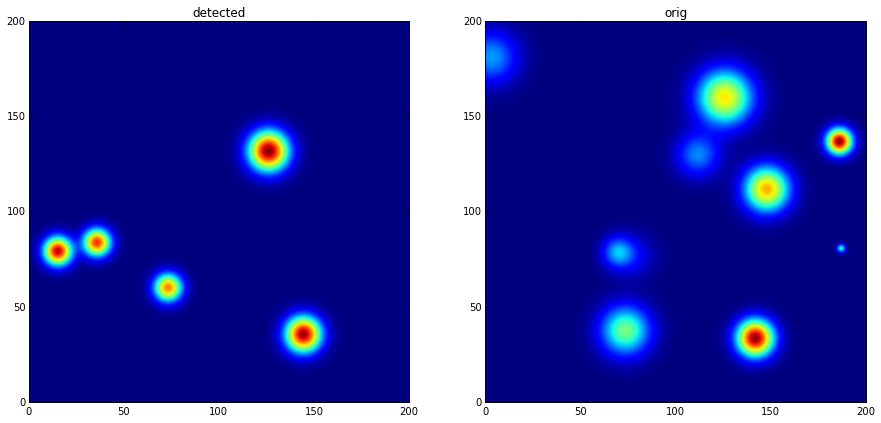

In [18]:
initial_bounds = np.array([[0, width], [0, height]])
k = get_peaks(initial_bounds)
sources = get_sources(k, all_vals)
look_at_results(sources)